# Simulating correlated price stocks in a multi-asset basket
This notebook demonstrates how to simulate price paths in a basket containing >2 correlated assets. To achieve this, it applies [Cholesky decomposition](https://en.wikipedia.org/wiki/Cholesky_decomposition)  on the correlation matrix and generates an array of correlated random numbers. The notebook only serves a narrow demonstration purpose and as such lacks certain user flexiblities.

## Import libraries

In [2]:
#Import libraries
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt, exp
from pandas_datareader import data
from matplotlib.ticker import FuncFormatter

## Set coefficient matrix
Observe that the number of stocks and the coefficient matrix $\Sigma$ are treated as constants. When adjusting manually, carefully check that the matrix dimensions align with the number of stocks and that the correlation matrix is semi-definite positive (requirement for Cholesky decomposition).

For this example, volatilies and correlation coefficients for the [Big Tech companies](https://en.wikipedia.org/wiki/Big_Tech)  over 2020 were calculated.

In [2]:
# Manually input number of stocks
# NUMBER_OF_STOCKS = 5

# STOCK_TICKERS = ["AAPL", "AMZN", "FB", "GOOG", "MSFT"]

# VOLATILITY_ARRAY =[0.029364897425919183, 0.024211461824768903, 0.02888393105895754, 0.02410220515718577, 0.02762892161687765]

# COEF_MATRIX = np.array([
#     [1.0000000000000000, 0.6971648047240692, 0.7384565370708003, 0.6798703149875049, 0.6815233837805931],
#     [0.6971648047240692, 1.0000000000000000, 0.8388918757956443, 0.7516701327272224, 0.7668565257541257],
#     [0.7384565370708003, 0.8388918757956443, 1.0000000000000000, 0.8522010326073503, 0.7624155054902461],
#     [0.6798703149875049, 0.7516701327272224, 0.8522010326073503, 1.0000000000000000, 0.8029761601663761],
#     [0.6815233837805931, 0.7668565257541257, 0.7624155054902461, 0.8029761601663761, 1.0000000000000000]
# ])

# print(COEF_MATRIX)

[[1.         0.6971648  0.73845654 0.67987031 0.68152338]
 [0.6971648  1.         0.83889188 0.75167013 0.76685653]
 [0.73845654 0.83889188 1.         0.85220103 0.76241551]
 [0.67987031 0.75167013 0.85220103 1.         0.80297616]
 [0.68152338 0.76685653 0.76241551 0.80297616 1.        ]]


In [39]:
NUMBER_OF_STOCKS = 5

tickers = ["AAPL", "AMZN", "FB", "GOOG", "MSFT"]

start_date = '2013-01-01'
end_date = '2020-10-31'

df = data.DataReader(tickers,'yahoo', start_date, end_date)
adj_close = df['Adj Close']
close = df['Close']

In [40]:
df

Attributes   Adj Close                                                    \
Symbols           AAPL         AMZN          FB         GOOG        MSFT   
Date                                                                       
2012-12-31   16.418938   250.869995   26.620001   352.369232   22.184826   
2013-01-02   16.939108   257.309998   28.000000   360.274597   22.940651   
2013-01-03   16.725300   258.480011   27.770000   360.483826   22.633337   
2013-01-04   16.259422   259.149994   28.760000   367.607117   22.209736   
2013-01-07   16.163782   268.459991   29.420000   366.003143   22.168209   
...                ...          ...         ...          ...         ...   
2020-10-26  114.002907  3207.040039  277.109985  1590.449951  207.360931   
2020-10-27  115.538803  3286.330078  283.290009  1604.260010  210.489883   
2020-10-28  110.187943  3162.780029  267.670013  1516.619995  200.056686   
2020-10-29  114.270447  3211.010010  280.829987  1567.239990  202.070297   
2020-10-30  107.869240  3036.149902  263.109985  1621.010010  199.849411   

Attributes       Close                                                    ...  \
Symbols           AAPL         AMZN          FB         GOOG        MSFT  ...   
Date                                                                      ...   
2012-12-31   19.006071   250.869995   26.620001   352.369232   26.709999  ...   
2013-01-02   19.608213   257.309998   28.000000   360.274597   27.620001  ...   
2013-01-03   19.360714   258.480011   27.770000   360.483826   27.250000  ...   
2013-01-04   18.821428   259.149994   28.760000   367.607117   26.740000  ...   
2013-01-07   18.710714   268.459991   29.420000   366.003143   26.690001  ...   
...                ...          ...         ...          ...         ...  ...   
2020-10-26  115.050003  3207.040039  277.109985  1590.449951  210.080002  ...   
2020-10-27  116.599998  3286.330078  283.290009  1604.260010  213.250000  ...   
2020-10-28  111.199997  3162.780029  267.670013  1516.619995  202.679993  ...   
2020-10-29  115.320000  3211.010010  280.829987  1567.239990  204.720001  ...   
2020-10-30  108.860001  3036.149902  263.109985  1621.010010  202.470001  ...   

Attributes        Open                                                    \
Symbols           AAPL         AMZN          FB         GOOG        MSFT   
Date                                                                       
2012-12-31   18.233213   243.750000   26.200001   348.693024   26.590000   
2013-01-02   19.779285   256.079987   27.440001   358.366760   27.250000   
2013-01-03   19.567142   257.269989   27.879999   361.111481   27.629999   
2013-01-04   19.177500   257.579987   28.010000   363.308228   27.270000   
2013-01-07   18.642857   262.970001   28.690001   366.351837   26.770000   
...                ...          ...         ...          ...         ...   
2020-10-26  114.010002  3198.739990  283.160004  1625.010010  213.850006   
2020-10-27  115.489998  3224.939941  278.760010  1595.670044  211.589996   
2020-10-28  115.050003  3249.300049  278.790009  1559.739990  207.669998   
2020-10-29  112.370003  3201.270020  276.549988  1522.359985  204.070007   
2020-10-30  111.059998  3157.750000  274.500000  1672.109985  203.500000   

Attributes       Volume                                                
Symbols            AAPL       AMZN          FB       GOOG        MSFT  
Date                                                                   
2012-12-31  659492400.0  3419000.0  60374500.0  4009773.0  42749500.0  
2013-01-02  560518000.0  3271000.0  69846400.0  5101651.0  52899300.0  
2013-01-03  352965200.0  2750900.0  63140600.0  4653778.0  48294400.0  
2013-01-04  594333600.0  1874200.0  72715400.0  5547717.0  52521100.0  
2013-01-07  484156400.0  4910000.0  83781800.0  3323812.0  37110400.0  
...                 ...        ...         ...        ...         ...  
2020-10-26  111850700.0  5901200.0  21322900.0  1853300.0  37111600.0  
2020-10-27   92

In [41]:
volatility = []

for ticker in tickers:
    asset = close[ticker]
    vol = np.sqrt(np.log(asset / asset.shift(1)).var()) * np.sqrt(252)
    volatility.append(vol)

In [42]:
volatility

[0.2870581250289104,
 0.3061428642263926,
 0.3423324966487216,
 0.2562801379232028,
 0.2660181039608255]

In [43]:
# returns = adj_close.pct_change().dropna()
returns = (1 + close.pct_change()).cumprod() - 1

In [44]:
# co_matrix = returns.cov()
co_matrix = returns.corr()

## Perform Cholesky decomposition
This cell performs the Cholesky decomposition on the coefficient matrix $\Sigma$, returning a matrix $R$ that satisfies $\Sigma=R R^*$ and $R^*$ being the conjugate transpose of $R$. Note that the other computations are only for validation purposes.

In [45]:
# Perform Cholesky decomposition on coefficient matrix
R = np.linalg.cholesky(co_matrix)

# Compute transpose conjugate (only for validation)
RT = R.T.conj()

# Reconstruct coefficient matrix from factorization (only for validation)
print(np.dot(R, RT))

[[1.         0.94301021 0.88242179 0.9030418  0.96261187]
 [0.94301021 1.         0.9240142  0.96089546 0.97526589]
 [0.88242179 0.9240142  1.         0.96961879 0.90172388]
 [0.9030418  0.96089546 0.96961879 1.         0.94946745]
 [0.96261187 0.97526589 0.90172388 0.94946745 1.        ]]


## Initialize simulation properties
For simplicitly, all stocks have the same initial price $S_{n,0}$ and the same volatility $v_n$.

In [186]:
T = 252                                                  # Number of simulated days
# stock_price_array = np.full((NUMBER_OF_STOCKS,T), 100.0) # Stock price, first value is simulation input 
volatility_array = volatility                            # Volatility (annual, 0.01=1%)
r = 0.01                                                 # Risk-free rate (annual, 0.01=1%)
dt = 1.0 / T                                             # Time increment (annualized)

In [187]:
# stock_price_array[1,t-1]

In [188]:
test = pd.DataFrame()

array = []

prices = [107.869240, 3036.149902, 263.109985, 1621.010010, 199.849411]

# for lis in stock_price_array:
#     for price in prices:
#         for num in lis:
#             num = price

# prices = [107.869240, 3036.149902, 263.109985, 1621.010010, 199.849411]

for price in prices:
    insidelist = []
    for i in range(252):
        insidelist.append(price)
    array.append(insidelist)

In [189]:
test.append(array).T

,0,1,2,3,4
0,107.86924,3036.149902,263.109985,1621.01001,199.849411
1,107.86924,3036.149902,263.109985,1621.01001,199.849411
2,107.86924,3036.149902,263.109985,1621.01001,199.849411
3,107.86924,3036.149902,263.109985,1621.01001,199.849411
4,107.86924,3036.149902,263.109985,1621.01001,199.849411
...,...,...,...,...,...
247,107.86924,3036.149902,263.109985,1621.01001,199.849411
248,107.86924,3036.149902,263.109985,1621.01001,199.849411
249,107.86924,3036.149902,263.109985,1621.01001,199.849411
250,107.86924,3036.149902,263.109985,1621.01001,199.849411


In [190]:
stock_price_array = test.append(array).T

In [191]:
stock_price_array

,0,1,2,3,4
0,107.86924,3036.149902,263.109985,1621.01001,199.849411
1,107.86924,3036.149902,263.109985,1621.01001,199.849411
2,107.86924,3036.149902,263.109985,1621.01001,199.849411
3,107.86924,3036.149902,263.109985,1621.01001,199.849411
4,107.86924,3036.149902,263.109985,1621.01001,199.849411
...,...,...,...,...,...
247,107.86924,3036.149902,263.109985,1621.01001,199.849411
248,107.86924,3036.149902,263.109985,1621.01001,199.849411
249,107.86924,3036.149902,263.109985,1621.01001,199.849411
250,107.86924,3036.149902,263.109985,1621.01001,199.849411


In [192]:
stock_price_array.iloc[0,0]

107.86924

## Run simulation
For each time step, the cell generates a number of standard normal numbers (randomly drawn) and multiplies this with the $R$ matrix obtained from the Cholesky decomposition, yielding an epsilon array with correlated values. Mathematically, this procedure is denoted by $[\epsilon_n]_{\forall n \in \mathcal{N}} =R[x_n]_{\forall n \in \mathcal{N}}$, with $\mathcal{N}$ being the set of assets. The epsilons $\epsilon_n$ are used as inputs for the boilerplate return formula as derived from the Black-Scholes model: $S_t=S_{t-1} * e^{\left(r_f - \frac{\sigma ^2}{2}\right)}  dt + \sigma  \sqrt{dt}  \epsilon_n$

In [201]:
for t in range(1, T):
    # Generate array of random standard normal draws
    random_array = np.random.standard_normal(NUMBER_OF_STOCKS)
    
    # Multiply R (from factorization) with random_array to obtain correlated epsilons
    epsilon_array = np.inner(random_array,R)

    # Sample price path per stock
    for n in range(NUMBER_OF_STOCKS):
        dt = 1 / T 
        S = stock_price_array.iloc[t-1,n]
        v = volatility_array[n]
        epsilon = epsilon_array[n]
        
        # Generate new stock price
        stock_price_array.iloc[t,n] = S * exp((r - 0.5 * v**2) * dt + v * sqrt(dt) * epsilon)

In [202]:
# import pandas as pd
# new = pd.DataFrame()
# new

In [203]:
stock_price_array

,0,1,2,3,4
0,104.321865,2926.845053,252.231600,1572.431186,194.284027
1,103.555273,2917.093632,253.352245,1572.427394,193.999208
2,104.537590,2951.236486,252.446820,1578.307134,195.443195
3,103.255951,2902.405668,247.907218,1556.040580,193.084378
4,103.545614,2929.260684,248.352664,1565.223278,194.484610
...,...,...,...,...,...
247,61.937974,1622.447334,119.462739,1012.428203,125.214915
248,60.858604,1605.356594,117.631388,1003.208467,123.322768
249,61.744457,1623.543319,119.952528,1015.259886,124.713485
250,61.579064,1629.708638,121.225208,1023.905725,124.547496


In [185]:
new = pd.DataFrame()
new

""


In [178]:
for i in range(NUMBER_OF_STOCKS):
    stock = tickers[i]
    prices = stock_price_array[i]
    new[stock] = prices

In [179]:
new

,AAPL,AMZN,FB,GOOG,MSFT
0,107.869240,3036.149902,263.109985,1621.010010,199.849411
1,108.002239,3014.567680,259.408232,1606.322484,199.446644
2,103.268255,2893.274278,249.553266,1559.796205,192.280633
3,107.004328,2996.079223,262.151989,1607.965230,198.344152
4,108.900670,3038.709009,266.774445,1631.578072,201.855112
...,...,...,...,...,...
247,96.443726,2421.903929,233.793750,1501.207204,174.653778
248,96.305070,2394.562307,233.137861,1495.967265,173.506724
249,96.318813,2388.455844,231.779901,1489.481971,173.651690
250,97.016966,2410.064001,233.399303,1504.293199,175.245179


In [121]:
return_series_adj = (new.pct_change()+ 1).cumprod() - 1

In [126]:
return_series_adj

0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
      ... 
247    0.0
248    0.0
249    0.0
250    0.0
251    0.0
Length: 252, dtype: float64

In [122]:
weights = [0.2,0.3,0.3,0.1,0.1]

In [123]:
weighted_return_series_adj = weights * (return_series_adj)

return_series_adj = weighted_return_series_adj.sum(axis=1)

# fig, ax = plt.subplots(figsize=(16,9))
# ax.plot(return_series_adj, label = 'weight')

# # return_series_adj_spy_tlt.plot(figsize=(16,9))
# ax.plot(return_series_adj['AAPL'] , label = 'AAPL')
# ax.plot(return_series_adj['AMZN'] , label = 'AMZN')
# ax.plot(return_series_adj['FB'] , label = 'FB')
# ax.plot(return_series_adj['GOOG'] , label = 'GOOG')
# ax.plot(return_series_adj['MSFT'] , label = 'MSFT')
# ax.legend()

In [124]:
return_series_close = (close.pct_change()+ 1).cumprod() - 1
weighted_return_series_close = weights * (return_series_close)
return_series_close = weighted_return_series_close.sum(axis=1)

In [125]:
ret = return_series_adj.tail(1)
print("Portfolio Return:", ret[-1].round(3))

# vol = np.sqrt(252) * np.log((return_series_close+1)/(return_series_close+1).shift(1)).std()
# print("Portfolio Volatility:", vol.round(3))

KeyError: -1

## Plot simulated paths
With the default settings, the price paths should be highly correlated.

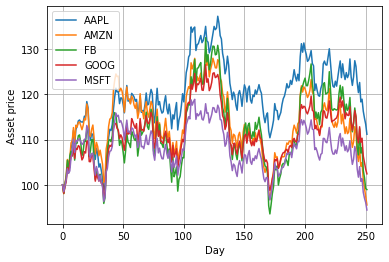

In [19]:
# Plot simulated price paths
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
array_day_plot = [t for t in range(T)]

for n in range(NUMBER_OF_STOCKS):
    ax.plot(array_day_plot, stock_price_array[n],\
                        label = '{}'.format(tickers[n]))

plt.grid()
plt.xlabel('Day')
plt.ylabel('Asset price')
plt.legend(loc='best')

plt.show()